In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from argparse import Namespace
from utilities3 import *
from PDE_Net import *
from train_utils import *

In [29]:
config_FNO = Namespace(
project_name = 'FNO',
sdf_file = r'I:\1-ML\工况合集\data\original_distance_data\allzone_distance_test3.npy',
train_file = r'I:\1-ML\工况合集\data\original_labels_data\allzone_label_test3.npy',

modes = 12,
width = 40,
activation = 'Sigmoid',
optim_type = 'SGD',
lr = 0.002,
weight_decay = 0.0004,
max_norm = 3.6,
dropout_p = 0,

epochs = 10000,
batch_size = 10,

save_path = r'I:\1-ML\工况合集\FNO_allzone\train_state'

)

In [30]:
sdf_data = np.load(config_FNO.sdf_file)
sdf_data = torch.as_tensor(sdf_data).float().to(device)
train_data = np.load(config_FNO.train_file)
train_data = torch.as_tensor(train_data).float().to(device)

sdf_data = sdf_data.permute(0,2,3,1)
x_normalizer = GaussianNormalizer(sdf_data)
x_data = x_normalizer.encode(sdf_data)
y_normalizer = GaussianNormalizer(train_data)
y_data = y_normalizer.encode(train_data)

In [31]:
activation = torch.nn.__dict__[config_FNO.activation]()
model = FNO2d(config_FNO.modes, config_FNO.modes, config_FNO.width, activation, config_FNO.dropout_p).to(device)
optimizer = optim.__dict__[config_FNO.optim_type](model.parameters(), lr = config_FNO.lr, weight_decay = config_FNO.weight_decay)
loss = nn.MSELoss()
load_model(config_FNO.save_path, model, optimizer)

Load model at time: 2023-12-13 11:25:16


In [32]:
model.eval()
with torch.no_grad():
	x,y = x_data.to(device), y_data.to(device)
	pred = model(x)
	pred = pred.permute(0,3,1,2)
	pred = y_normalizer.decode(pred)
	y = y_normalizer.decode(y)
	loss_val = loss(pred.clone(), y.clone())
	print(loss_val)


tensor(0.0023, device='cuda:0')


In [19]:
print(pred.shape)

torch.Size([1, 3, 301, 801])


[]

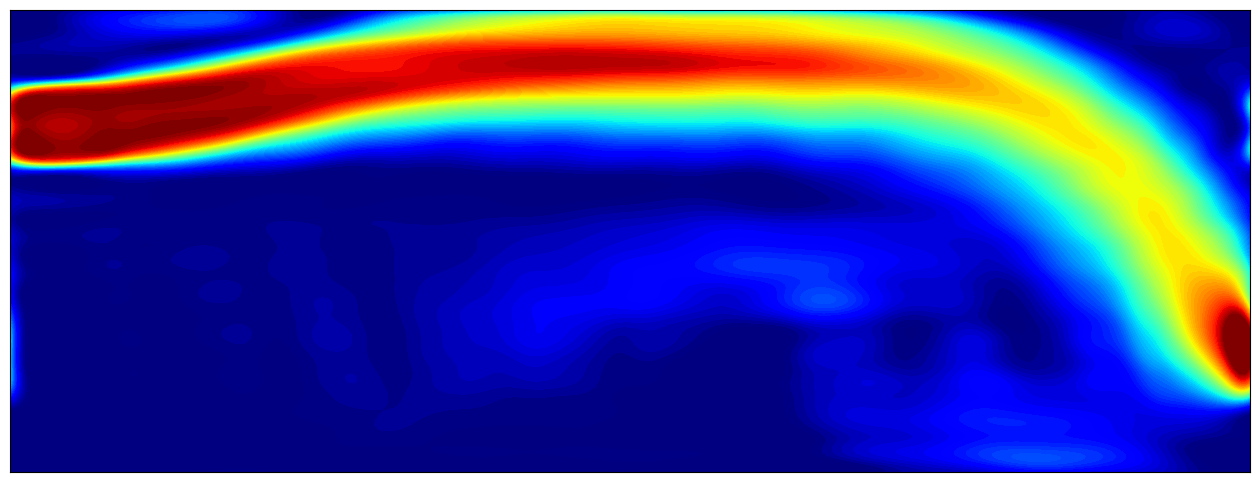

In [33]:
pred_data = pred.cpu().numpy()
index = 0
pltj,ax = plt.subplots(1,figsize=(16,6))
x_values = np.linspace(0, 8000, 801)
y_values = np.linspace(0, 3000, 301)
xx, yy = np.meshgrid(x_values, y_values)
ax.contourf(xx,yy,pred_data[index,0],100, cmap='jet', vmin=0, vmax=1)
# plt.imshow(mag, cmap='jet', vmin=0, vmax=1)
# plt.xlim(0,8000)
# plt.ylim(0,3000)
# plt.colorbar()
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('Graph/FNO_pred_6.png', dpi=600)

[]

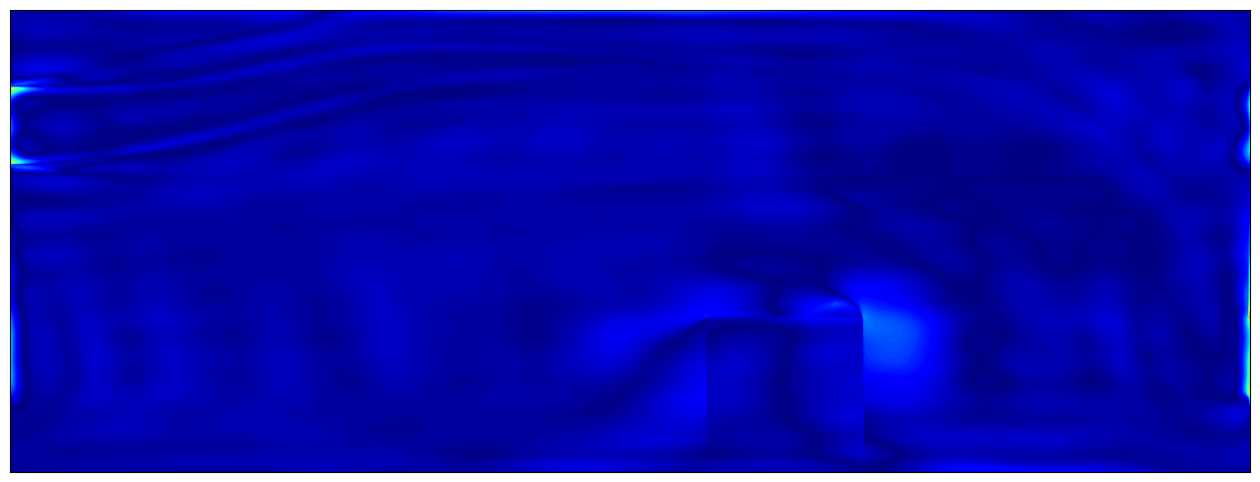

In [34]:
truth_data = y.cpu().numpy()
error = np.abs(pred_data-truth_data)
pltj,ax = plt.subplots(1,figsize=(16,6))
x_values = np.linspace(0, 8000, 801)
y_values = np.linspace(0, 3000, 301)
xx, yy = np.meshgrid(x_values, y_values)
ax.contourf(xx,yy,error[index,0],100, cmap='jet', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig(r'Graph/FNO_error_test3.png', dpi=600)